In [1]:
import numpy as np
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2
from copy import deepcopy
import time
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import itertools

# Dynamic Optimization Problem: Dentists

We start of by defining a set of parameters and then build our cost function that our agent is facing when deciding on going to the dentist or not. We plot our cost function. 
The basic idea is that it costs to go to the dentist every time you go, but if you postpone your check ups the total cost will increase.

In [2]:
par = SimpleNamespace()
par.x = 0 #x being the level of usage of your teeth
par.FC = 10 #Fixed cost of going to the dentist
par.MC = 2 #Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.beta = 0.6 #Discount factor
par.exponent = 2 #How bad your teeth decay if you don't see a dentist
par.gamma = 0.9
par.T = 3
par.boost = 10
#par.x_max = 25  # Maximum teeth quality level
par.threshold = 5 #threshold level to account for the severity of toothache  
par.weight = 4 #weight of toothache severity relative to the disutility caused by tooth decay


Defining a cost function (cost_dentist) that calculates the cost of going to the dentist or not, based on input parameters.

In [3]:
def cost_dentist(par, d, x_t):
    if d == 0: 
        return  0 #cost of not going to the dentist 
    if d == 1: 
        return int(par.FC + par.MC*x_t) #cost of going to the dentist 

Defining a function (teeth_decay) that reflects how a persons teeth transition over time based on input parameters.

In [4]:
def teeth_decay(par, d, x_t): #How your teeth are transitioning from one time period to the next
    if d == 0:
        x_1 = int(x_t**par.exponent + 3) #Decay of teeth of not going based on current state (x_t), an exponent and a constant (3) 
    else:
        x_1 = int(max(x_t - par.boost, 0)) #improvement of going to the dentist (current state (x_t) or a maximum of a reset stage of 0)
    return x_1

Defining a function that implements if a person choose a healthy or non-healthy lifestyle. When healthy, the decay rate of a persons teeth will be lower compared to non-healthy aswell as the improvement will be faster when choosing to go to a dentist. 

In [5]:
def teeth_decay_lifestyle(par, d, x_t, is_healthy):
    if is_healthy:
        if d == 0:
            x_1 = int(x_t ** par.exponent * 0.95 + 2) # slower decay with a 5% reduction
        else:
            x_1 = int(max(x_t - par.boost * 1.2, 0)) # faster improvement with a 20% boost
    else:
        if d == 0:
            x_1 = int(x_t ** par.exponent * 1.05 + 4) # faster decay with a 5% increase
        else:
            x_1 = int(max(x_t - par.boost * 0.8, 0)) # slower improvement with a 20% reduction
    return x_1

Defining a function (disutil_ache) that calculates the disutility caused by toothache based on a persons current teeth state. The diutility increases faster for x_t > 2.

In [6]:
def disutil_ache(par, x_t): 
    if x_t < 2: 
        disutil = 3
    else: 
        disutil = int((np.sqrt(x_t) * par.gamma + x_t))
    return disutil

Defining a function (disutil_ache_threshold) that calculates the disutility caused by toothache based on a persons current teeth state in relation to a threshold level

In [7]:
def disutil_ache_threshold(par, x_t): 
    if x_t >= par.threshold:
        disutil = int((par.weight * (x_t + par.threshold))**(1 - par.gamma) / (1 - par.gamma))
    else:
        disutil = int((x_t**(1-par.gamma) - 1) / (1 - par.gamma))
    return int(disutil)

Defining a total utility function (total_util)

In [8]:
def total_util(par, d, x_t):
    return -cost_dentist(par, d, x_t) - disutil_ache(par, x_t)

Defining a total utility function (total_util_threshold) 

In [9]:
def total_util_threshold(par, d, x_t):
    return -cost_dentist(par, d, x_t) - disutil_ache_threshold(par, x_t)

In [10]:
for i in range(0,10):
    print(disutil_ache(par, i)) 
#Disutility increases as i increases, indicating that toothache becomes more 
#unpleasant as the severity of the toothache increases

3
3
3
4
5
7
8
9
10
11


In [11]:
for i in range(0,10):
    print(disutil_ache_threshold(par, i)) 

-10
0
0
1
1
14
14
14
14
14


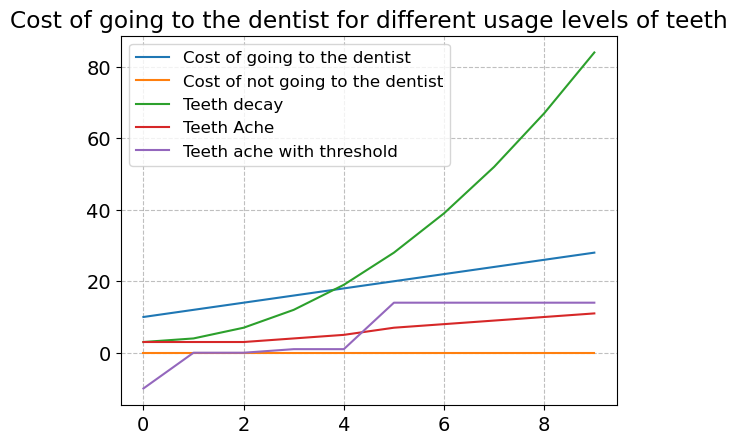

In [17]:
c_going = []
c_not_going = []
decay = []
ache = []
ache_threshold = []

for i in range(0,10):
    c_going.append(cost_dentist(par,1, i))
    c_not_going.append(cost_dentist(par,0, i))
    decay.append(teeth_decay(par, 0, i))
    ache.append(disutil_ache(par, i))
    ache_threshold.append(disutil_ache_threshold(par, i))
        

plt.plot(c_going, label='Cost of going to the dentist')
plt.plot(c_not_going, label='Cost of not going to the dentist')
plt.plot(decay, label='Teeth decay')
plt.plot(ache, label='Teeth Ache')
plt.plot(ache_threshold, label='Teeth ache with threshold')
plt.title('Cost of going to the dentist for different usage levels of teeth')
plt.legend(fontsize=12)
plt.show()



In [16]:
ache_threshold

[-10, 0, 0, 1, 1, 14, 14, 14, 14, 14]

In [ ]:
tot_util_go = []
tot_util_no = []

for i in range(0,20):
    tot_util_go.append(total_util(par, d = 1 , x_t= i))
    tot_util_no.append(total_util(par, d = 0 , x_t = i))


plt.plot(tot_util_no, label='Total utility of not going')
plt.plot(tot_util_go, label='Total utility of going')
plt.title('Total utility')
plt.legend()
plt.show()

Using total utility with threshold

In [ ]:
tot_util_go = []
tot_util_no = []

for i in range(0,20):
    tot_util_go.append(total_util_threshold(par, d = 1 , x_t= i))
    tot_util_no.append(total_util_threshold(par, d = 0 , x_t = i))


plt.plot(tot_util_no, label='Total utility of not going')
plt.plot(tot_util_go, label='Total utility of going')
plt.title('Total utility')
plt.legend()
plt.show()

In [ ]:
#Say we start with some value and live for t time periods and you don't go to the dentist in the last time period.

#This is to get all possible combinations of decisions. Imagine every path of the decision tree
def n_combinations(t):
    digits = (0, 1)
    return list(itertools.product(digits, repeat=t-1))

x_start = 0
time = 10
possible_paths = n_combinations(time) #Create all decision combinations, excluding the last time period (d==0)
n_paths = len(possible_paths) #Game starts in t1 with a t0 value. 
x = np.zeros((n_paths, time)) #decay_path_matrix
x[:,0] = x_start #Change the first column, hence the starting value
a = np.zeros((n_paths, time)) #age path
v = np.zeros((n_paths,time+1))#value_matrix
d_index = np.zeros((n_paths)) #Initiate
decision_indexes = [] #Keeping track of indexes and storing values
for index, val in enumerate(possible_paths):
    #print('Decision path: ', index,val)
    for t, d in enumerate(val): 
        x_next = teeth_decay(par, d=d, x_t=x[index,t]) #You always start with zero
        x[index, (t+1)] = x_next
        v[index, (t+1)] = (par.beta**t)*total_util(par, d=d, x_t=x[index, t])
        #print('Dental usage in period', t, ' = ', x[index, t])
    v[index, -1] = (par.beta**(time+1))*total_util(par, d=0, x_t=x[index, -1])
    best_path = v.sum(axis=1).argmax() #The decision path maximizing total utility 
    best_decisions = possible_paths[best_path] #FIGURE OUT 
    
print(best_decisions,x[best_path])

In [ ]:
#Say we start with some value and live for t time periods and you don't go to the dentist in the last time period.

#This is to get all possible combinations of decisions. Imagine every path of the decision tree
def n_combinations(t):
    digits = (0, 1)
    return list(itertools.product(digits, repeat=t-1))

x_start = 0
time = 10
possible_paths = n_combinations(time) #Create all decision combinations, excluding the last time period (d==0)
n_paths = len(possible_paths) #Game starts in t1 with a t0 value. 
x = np.zeros((n_paths, time)) #decay_path_matrix
x[:,0] = x_start #Change the first column, hence the starting value
a = np.zeros((n_paths, time)) #age path
v = np.zeros((n_paths,time+1))#value_matrix
d_index = np.zeros((n_paths)) #Initiate
decision_indexes = [] #Keeping track of indexes and storing values
age=0

for index, val in enumerate(possible_paths):
    #print('Decision path: ', index,val)
    for t, d in enumerate(val): 
        x_next = teeth_decay(par, d=d, x_t=x[index,t]) #You always start with zero
        x[index, (t+1)] = x_next
        v[index, (t+1)] = (par.beta**t)*total_util_threshold(par, d=d, x_t=x[index, t])
        #print('Dental usage in period', t, ' = ', x[index, t])
    v[index, -1] = (par.beta**(time+1))*total_util_threshold(par, d=0, x_t=x[index, -1])
    best_path = v.sum(axis=1).argmax() #The decision path maximizing total utility 
    best_decisions = possible_paths[best_path] #FIGURE OUT 
    
print(best_decisions,x[best_path])

In [ ]:
# Initialize value function
V = np.zeros((par.x_max+1,par.T))

# Iterate over time periods
for t in range(par.T-1, -1, -1):
    # Iterate over teeth quality levels
    for x in range(par.x_max+1):
        # Initialize variables
        min_cost = np.inf
        best_d = None

        if t == par.T: 
            total_cost = disutil_ache(par, x) ##Don't go to the dentist in the last time period, but endure pain
            best_d = 0
        
        else: 
            # Iterate over possible decisions
            for d in [0, 1]:
                # Calculate cost of current decision
                cost = cost_dentist(par, d, x)
                decay = teeth_decay(par, d, x_t, n)
                ache = disutil_ache(par, x)
                future_cost = par.beta*V[x,t-1]
                total_cost = cost + future_cost + ache
                
        # Update minimum cost and best decision
        if total_cost < min_cost:
            min_cost = total_cost
            best_d = d
            
        # Update value function
        V[x,t] = min_cost
        
        # Save best decision
        if best_d == 0:
            decision = 'Do not go to the dentist'
        else:
            decision = 'Go to the dentist'
        
        # Print results
        print(f"Time period: {t}, Teeth quality level: {x}, Best decision: {decision}, Expected cost: {min_cost}")

In [ ]:
V

# Version 2

In [ ]:
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Define the parameters for the dentist model
DentistParams = namedtuple('DentistParams', ['FC', 'MC', 'alpha', 'beta', 'gamma', 'pr', 'budget'])
par = DentistParams(FC=10, MC=2, alpha=0.5, beta=0.95, gamma=0.5, pr=0.8, budget=20)

# Define the initial conditions for the model
x0 = 0
T = 5

# Solve the dentist model and print the results
x, c, u, cost, discounted_utility, d, total_discounted_utility, total_cost = solve_dentist_model(par, x0, T)
print("x: ", x)
print("c: ", c)
print("u: ", u)
print("cost: ", cost)
print("discounted_utility: ", discounted_utility)
print("d: ", d)
print("total_discounted_utility: ", total_discounted_utility)
print("total_cost: ", total_cost)
plt.plot(u)
plt.plot(x)
plt.plot(c)
plt.plot(d)
plt.plot(cost)
plt.plot(discounted_utility)
plt.plot(total_discounted_utility)
plt.plot(total_cost)


In [ ]:
par = SimpleNamespace()
par.x = 0 #x being the level of usage of your teeth
par.FC = 10 #Fixed cost of going to the dentist
par.MC = 2 #Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.alpha = 0.5#parameter in the utility function 
par.beta = 0.9 #Discount factor
par.gamma = 1.5 #How bad your teeth decay if you don't see a dentist
par.pr = 0.1 #the probability of needing a filling 


In [ ]:
def solve_dentist_model(par, x, T):
    # Initialize arrays to store results
    x = np.zeros(T+1)
    c = np.zeros(T+1)
    u = np.zeros(T+1)
    cost = np.zeros(T+1)
    discounted_utility = np.zeros(T+1)
    d = np.zeros(T+1, dtype=int)

    # Set initial values
    x[0] = 0
    c[0] = 0
    u[0] = 0
    cost[0] = 0
    discounted_utility[0] = 0
    d[0] = 0

    for t in range(1, T+1):
        # Compute costs and benefits of going to the dentist and not going
        cost_dentist = par.FC + par.MC * x[t-1]
        discounted_utility_dentist = (par.alpha * x[t-1]**par.gamma) / (1 + par.beta)
        utility_no_dentist = (x[t-1]**par.gamma) / (1 + par.beta**(t-1))

        # Compute expected utility of going to the dentist and not going
        expected_utility_dentist = par.pr * discounted_utility_dentist + (1 - par.pr) * utility_no_dentist
        expected_utility_no_dentist = utility_no_dentist

        # Choose action that maximizes expected utility
        if expected_utility_dentist >= expected_utility_no_dentist and cost_dentist <= par.budget:
            x[t] = x[t-1] + 1
            c[t] = cost_dentist
            u[t] = discounted_utility_dentist
            cost[t] = cost_dentist
            discounted_utility[t] = discounted_utility_dentist
            d[t] = 1
        else:
            x[t] = x[t-1]
            c[t] = 0
            u[t] = utility_no_dentist
            cost[t] = 0
            discounted_utility[t] = utility_no_dentist
            d[t] = 0
    
            

    # Compute total discounted utility and cost
    total_discounted_utility = np.sum(discounted_utility)
    total_cost = np.sum(cost)

    # Return results
    return x, c, u, cost, discounted_utility, d, total_discounted_utility, total_cost



In [ ]:
# Print the results
print("x:", x)
print("c:", c)
print("u:", u)
print("cost:", cost)
print("discounted_utility:", discounted_utility)
print("d:", d)
print("total_discounted_utility:", total_discounted_utility)
print("total_cost:", total_cost)

### Possible extensions: 

° Income and savings 

° Life style choices (healthy or unhealthy) with different impacts on x.

° Varying MC and FC

° Age impacting decay of teeth. Say after 50 years, consequences of not going (increase in x if d=0) goes up. Or marginal cost could double.

° Implementing a subsidy of one dollar. Does it make more sense to subsidize the marginal or the fixed cost. 